# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
The outage dataset has information about each incident of a power outage in the United States. The prediction problem that I chose to look at was the time duration of the power outage. I used a regression model to look at this problem. I disregarded columns about how much residential customers and industrial customers are in the area of the outage, since I thought them to not be directly relevant to the outage incident. Instead I picked out columns of month, state, category of cause of the outage, the number of customers affected by the outage, total number of customers, and total amount of sales.

I chose RMSE as the measure to evaluate my models. I chose RMSE becuase RMSE shows how much error there is between my model's prediction and the actual dataset. 

Before the modelings, I noticed there were missing values in my dataset. I did not impute and dropped only the rows that were missing my target value: duration of the outage. With the values missing in the total sales column and the number of customers affected column, I imputed them by using the distribution imputation.

### Baseline Model
For my baseline model I chose to incorporate all the features that I chose to be directly relevant to the outage incident. I chose 2 quantitative features, which were the number of customers affected and the amount of total sales. I also chose 1 nominal, which was the month or the outage, and 2 nominal, which were the state of the outage and the cause category of the outage. I grouped the nominal and ordinal features into categorical and used one-hot coding so that I could use them to train my baseline model along with my quantitative features, which I used them as they were given to me. 

I used test train split to divide my dataset into test set and train set. I used linear regression to train my model and make predictions by using the features. My baseline model resulted in an RMSE of 5640 and a R squared score of 0.213, which tells me that my baseline model is not making good predictions about the duration of the outages, given the features. I know that this can be improved by better engineering the features.

### Final Model
For my final model, I divided the features into categorical and quantitative. The categorical columns were month, cause category, and u.s. state. For the categorical features, along with one-hot encoding, I also used Principal Component Analysis, also known as PCA. The reason I chose PCA is because it is known to lower the dimensionality of the features without losing much information, which could effectively help me in better intrepretting the features. The categorical features were total customers, total sales, and the number of customers that were affected. For the quantitative features, in order to better spread them out, I used logarithmic scaling on these features. I attempted normalization and standardization, but I realized that these would merely put them on the relatively exact positions from one another, merely changing the x-axis. Log scaling on the other hand, showed better relationship between the features and the duration of the outage. After these two preprocessing engineerings, I use linear regression to fit, train and predict outage durations.

The final model with these two extra engineerings incorproated resulted in a RMSE of 3784 and a R squared score of 0.213. Although I still think the final model is not doing pretty well of predicting the duration of outage with that RMSE and still has room for developments and improvements, I still want to recognize that the decrease in RMSE of over 1400 is quite meaningful.

### Fairness Evaluation
In order to evaluate fairness, I used the difference between the root mean squared error(RMSE) of the baseline model and the final model. I will use them to get the difference between the two, or if the final model resulted in a smaller RMSE than the baseline model did. The RMSE is a good statistic to use because it shows how apart the model's prediction is from the actual values. Therefore my test statistic will be the difference of RMSE. My null hypothesis will be that the model is fair and that both the baseline model and the final model do not result in vastly different predictions, leading to roughly similar RMSE for both models. My alternative hypothesis is that the models are not fair, and that the RMSE of the final model is smaller than the baseline model by a meaningful amount. I will use a permutation test for this and set a significance level of 0.05 as the threshhold.

I chose to run 1000 simulations of running both models and computing the difference of the two RMSEs. The resulting p-value was 0.403, which was way above the threshhold 0.05 that I ser previously. Therefore we fail to reject the null hypothesis that says that the final model and the baseline model have approximately similar predictions and thus, distributions as well. This means that although the final model was one imporved from the baseline model, it was not a model significantly different from the baseline model. However based on the permutation test, it would be easily said that my model is fair.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA


In [3]:
outage = pd.read_excel('outage')
outage.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


In [4]:
outage = pd.read_excel('outage', skiprows=[0, 1, 2, 3, 4, 6])
outage.head()

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,NaN,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,NaN,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,NaN,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,NaN,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,NaN,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


### Baseline Model

I selected columns that seemed to be relevant to each outage incident.

In [5]:
outage_info_columns = ['MONTH', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS', 'TOTAL.SALES']
outage_info = outage[outage_info_columns]
outage_info.head()

,MONTH,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS,TOTAL.SALES
0,7.0,Minnesota,severe weather,3060.0,70000.0,2595696,6562520.0
1,5.0,Minnesota,intentional attack,1.0,NaN,2640737,5284231.0
2,10.0,Minnesota,severe weather,3000.0,70000.0,2586905,5222116.0
3,6.0,Minnesota,severe weather,2550.0,68200.0,2606813,5787064.0
4,7.0,Minnesota,severe weather,1740.0,250000.0,2673531,5970339.0


In [6]:
outage_info.isnull().sum()

MONTH                   9
U.S._STATE              0
CAUSE.CATEGORY          0
OUTAGE.DURATION        58
CUSTOMERS.AFFECTED    443
TOTAL.CUSTOMERS         0
TOTAL.SALES            22
dtype: int64

In [7]:
len(outage_info)

1534

My target column is the outage duration, so I cannot impute the values of this column. I am not yet sure on which column the outage duration column is dependent on. So I will drop the outage incidents that do not have the outage duration recorded.

In [8]:
outage_info.dropna(subset=['OUTAGE.DURATION'], inplace = True)

In [9]:
len(outage_info)

1476

In [10]:
outage_info.isnull().sum()

MONTH                   0
U.S._STATE              0
CAUSE.CATEGORY          0
OUTAGE.DURATION         0
CUSTOMERS.AFFECTED    420
TOTAL.CUSTOMERS         0
TOTAL.SALES            12
dtype: int64

For  the values missing in columns CUSTOMERS.AFFECTED and TOTAL.SALES, I will impute them with distribution, since they can be said to be Missing at Random, letting the value missing to be conditionally ignorable.

In [11]:
# impute TOTAL.SALES column with distribution
tot_sales_null = outage_info['TOTAL.SALES'].isnull().sum()
fill_tot_sales = outage_info['TOTAL.SALES'].dropna().sample(tot_sales_null, replace=True)
fill_tot_sales.index = outage_info.loc[outage_info['TOTAL.SALES'].isnull()].index
outage_filled_sales = outage_info.fillna({'TOTAL.SALES': fill_tot_sales})
outage_filled_sales.isnull().sum()
print(fill_tot_sales)

103      7669655.0
171     22424411.0
218      1040930.0
417      7827652.0
605      7146468.0
743      8514890.0
762     11287927.0
827      3843905.0
900       996096.0
1419     8139959.0
1520     5814212.0
1528    21351409.0
Name: TOTAL.SALES, dtype: float64


In [12]:
# impute CUSTOEMRS.AFFECTED column with distribution
cust_affect_null = outage_filled_sales['CUSTOMERS.AFFECTED'].isnull().sum()
fill_cus_affect = outage_filled_sales['CUSTOMERS.AFFECTED'].dropna().sample(cust_affect_null, replace=True)
fill_cus_affect.index = outage_info.loc[outage_filled_sales['CUSTOMERS.AFFECTED'].isnull()].index
outage_filled = outage_filled_sales.fillna({'CUSTOMERS.AFFECTED': fill_cus_affect})
outage_filled.isnull().sum()

MONTH                 0
U.S._STATE            0
CAUSE.CATEGORY        0
OUTAGE.DURATION       0
CUSTOMERS.AFFECTED    0
TOTAL.CUSTOMERS       0
TOTAL.SALES           0
dtype: int64

My dataset does not have any NaN or null values, so now I will train the baseline model with the columns I picked for being relevant to the outage event. For columns with categorical values like MONTH, U.S._STATE, and CAUSE.CATEGORY, I will use one hot coding. For the columns with quantitative values like CUSTOMERS.AFFECTED, TOTAL.CUSTOMERS, and TOTAL.SALES, I will use them as they are given, and not perform any modifications in the baseline model.

In [13]:
# one hot encoding for the categorical features below
categorical = ['MONTH', 'U.S._STATE', 'CAUSE.CATEGORY']

categorical_transformer = Pipeline([('one-hot', OneHotEncoder())])
preprocessing = ColumnTransformer(transformers=[('categorical', categorical_transformer, categorical)])

# pipeline for all features, regardless of type
pl = Pipeline(steps=[('preprocessing', preprocessing), ('lin reg', LinearRegression())])
X = outage_filled.drop('OUTAGE.DURATION', axis=1)
y = outage_filled['OUTAGE.DURATION']
pl.fit(X, y)
prediction = pl.predict(X)

In [14]:
pl

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categorical',
                                                  Pipeline(memory=None,
                                                           steps=[('one-hot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='error',
                                                                                 sparse=True))],
                                       

In [15]:
prediction

array([3281.30391464,  310.80641862, 5041.29408953, ...,  720.00033849,
        120.00797806,  120.00797806])

I will use train test split and get the root mean squared error and the r squared

In [16]:
# (X and y are the same variables from above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# (list of categorical features is the same as above)
cat_train_transformer = Pipeline([('one hot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('categorical', cat_train_transformer, categorical)])

pl_baseline = Pipeline(steps=[('preprocessing', preprocessor), ('lin reg', LinearRegression())])
pl_baseline.fit(X_train, y_train)
prediction_baseline = pl_baseline.predict(X_test)
rmse_baseline = np.sqrt(np.mean((prediction_baseline - y_test)**2))

In [30]:
rmse_baseline

5640.822711937817

In [31]:
r2_baseline = pl_baseline.score(X, y)
r2_baseline

0.2131587202411549

### Final Model

To make my RMSE smaller, I will log-scale the quantitative features, which are the total sales and the customers affected. This will help improve the model because the log scaling will help spreadout the datasets from one another.

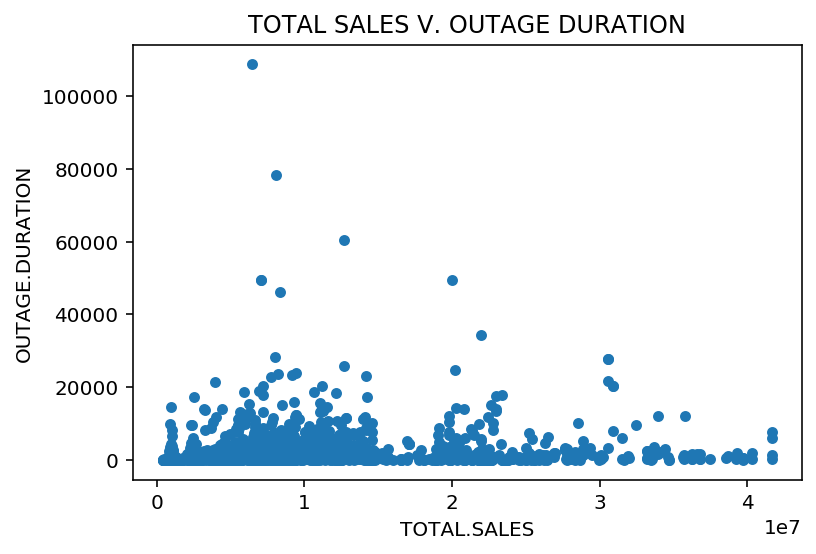

In [32]:
# exploration of scaling total sales
outage_plot = outage_filled.copy()
outage_plot.plot(kind='scatter', x='TOTAL.SALES', y='OUTAGE.DURATION', title='TOTAL SALES V. OUTAGE DURATION')

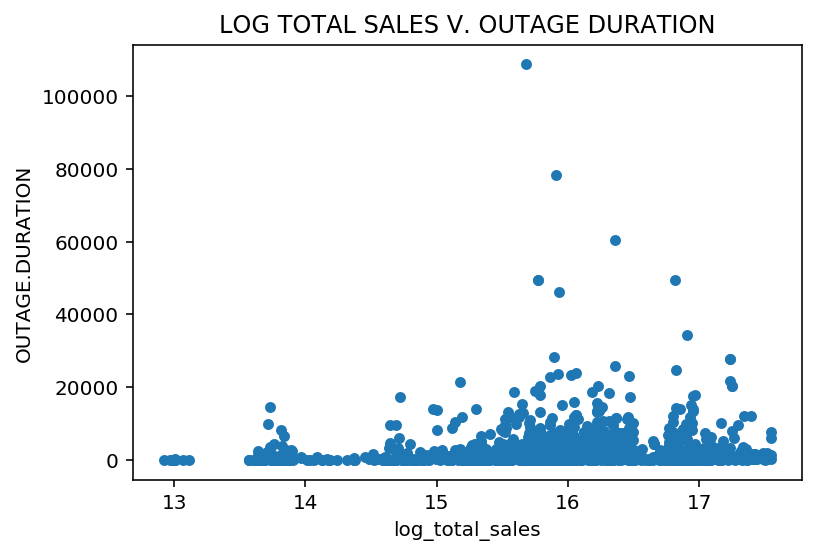

In [33]:
# log scaled total sales
outage_plot['log_total_sales'] = np.log(outage_plot['TOTAL.SALES'])
outage_plot.plot(kind='scatter', x='log_total_sales', y='OUTAGE.DURATION', title='LOG TOTAL SALES V. OUTAGE DURATION')

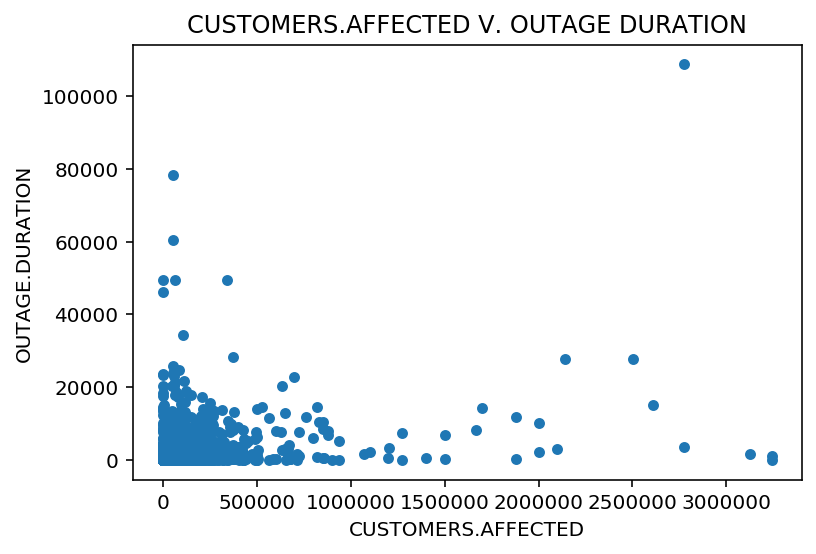

In [34]:
# plot customers affected vs. outage durations
outage_plot.plot(kind='scatter', x='CUSTOMERS.AFFECTED', y='OUTAGE.DURATION', title='CUSTOMERS.AFFECTED V. OUTAGE DURATION')

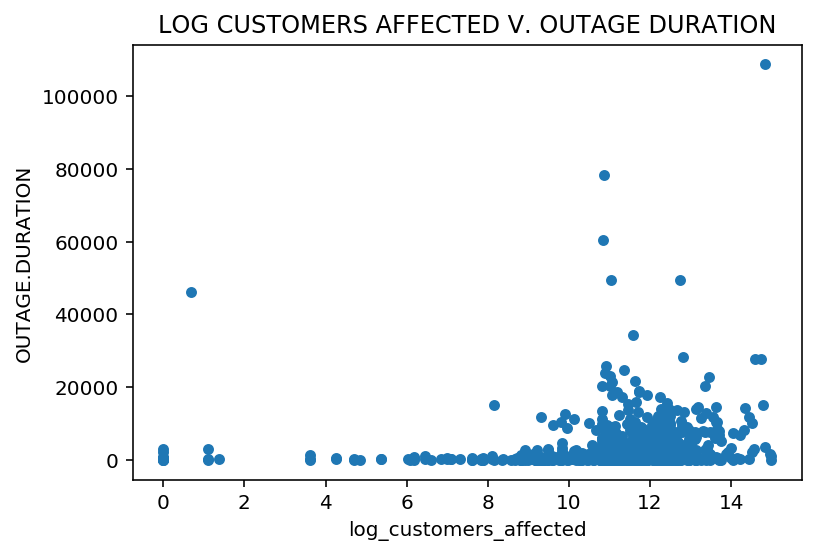

In [35]:
# plot log scaled customers affected v. outage duration
outage_plot['log_customers_affected'] = np.log(outage_plot['CUSTOMERS.AFFECTED'])
outage_plot.plot(kind='scatter', x='log_customers_affected', y='OUTAGE.DURATION', title='LOG CUSTOMERS AFFECTED V. OUTAGE DURATION')

I will apply principal component analysis to the categorical columns to further reduce linear dimensionality. This will help better interpret the categorical data in the model

In [85]:
# final model training using engineered features

X = outage_filled.drop('OUTAGE.DURATION', axis=1)
y = outage_filled['OUTAGE.DURATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

categorical_cols = ['MONTH','U.S._STATE','CAUSE.CATEGORY']
categorical_pl = Pipeline([('one hot', OneHotEncoder(handle_unknown='ignore', sparse=False)), ('pca', PCA(svd_solver='full'))])

quantitative_cols = ['TOTAL.SALES', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS']
quantitative_transformer = FunctionTransformer(np.log1p)

preproc_final = ColumnTransformer(transformers=[('categorical', categorical_pl, categorical_cols)])

pl_final = Pipeline(steps=[('preproc', preproc_final), ('lin reg', LinearRegression())])
pl_final.fit(X_train, y_train)
final_prediction = pl_final.predict(X_test)
final_rmse = np.sqrt(np.mean((final_prediction - y_test)**2))
final_r2 = pl_final.score(X, y)

In [86]:
final_rmse

3784.247955528876

In [87]:
final_r2

0.21385243385247957

In [89]:
(final_rmse - rmse_baseline, final_r2 - r2_baseline)

(-1453.3809882001847, 0.00069371361132467)

By incorporating pricipal component analysis for the categorical columns and log scaling the quantitative columns, I reduced the RMSE by 1453 and increased the R2 by 0.00069. Although the increase in R2 value is very small or almost ignorable, I think the decrease in RMSE is meaningful in making more accurate predictions of the outage durations based on the information about the outage events.

### Fairness Evaluation

In order to evaluate fairness, I will use the root mean squared error(RMSE) of the baseline model and the final model. I will use them to get the difference between the two, or if the final model resulted in a smaller RMSE than the baseline model did. The RMSE is a good statistic to use because it shows how apart the model's prediction is from the actual values. Therefore my test statistic will be the difference of RMSE. My null hypothesis will be that the model is fair and that both the baseline model and the final model do not result in vastly different predictions, leading to roughly similar RMSE for both models. My alternative hypothesis is that the models are not fair, and that the RMSE of the final model is smaller than the baseline model by a meaningful amount. I will use a permutation test for this and set a significance level of 0.05 as the threshhold.

In [90]:
# observed test statistic: absolute difference between RMSE of final model and RMSE of baseline model
observed = np.abs(final_rmse - rmse_baseline)
observed

1453.3809882001847

In [64]:
# permutation test of 1000 repetitions
N = 1000

rmse_differences = []

for i in range(N):
    # split the dataset and set X and y to train and test sets
    X = outage_filled.drop('OUTAGE.DURATION', axis=1)
    y = outage_filled['OUTAGE.DURATION']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # baseline model simulation
    categorical = ['MONTH', 'U.S._STATE', 'CAUSE.CATEGORY']
    cat_train_transformer = Pipeline([('one hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[('categorical', cat_train_transformer, categorical)])
    pl_baseline = Pipeline(steps=[('preprocessing', preprocessor), ('lin reg', LinearRegression())])
    pl_baseline.fit(X_train, y_train)
    prediction_baseline = pl_baseline.predict(X_test)
    rmse_baseline = np.sqrt(np.mean((prediction_baseline - y_test)**2))

    

    # final model simulation
    categorical_cols = ['MONTH','U.S._STATE','CAUSE.CATEGORY']
    categorical_pl = Pipeline([('one hot', OneHotEncoder(handle_unknown='ignore', sparse=False)), ('pca', PCA(svd_solver='full'))])

    quantitative_cols = ['TOTAL.SALES', 'CUSTOMERS.AFFECTED']
    quantitative_transformer = FunctionTransformer(np.log1p)

    preproc_final = ColumnTransformer(transformers=[('categorical', categorical_pl, categorical_cols)])

    pl_final = Pipeline(steps=[('preproc', preproc_final), ('lin reg', LinearRegression())])
    pl_final.fit(X_train, y_train)
    final_prediction = pl_final.predict(X_test)
    final_rmse = np.sqrt(np.mean((final_prediction - y_test)**2))

    # get differences between the rmse of final model and rmse of baseline model
    diff = np.abs(rmse_baseline - final_rmse)

    # save difference of rmse to array
    rmse_differences.append(diff)

    

In [65]:
# compute p-value
p_value = np.count_nonzero(rmse_differences >= observed) / N
p_value

0.403

The p-value is 0.403, which is significantly bigger than the threshhold of 0.05 that I previously set. Therefore we fail to reject the null hypothesis that says that the final model and the baseline model have approximately similar predictions and thus, distributions as well.